## Spatial transcriptomics analysis with multiple slices

In [ ]:
library("Seurat")
library("tidyverse")
library("patchwork")
library("ggplot2")


input_data_dir <- "/home/Data_download/zhaojw/Spatial_data/HCC/HRA000437-outs"
sample_list <- list.files(input_data_dir)
sample_list <- sample_list[c(1:2,4:5)]

## file path
samples_dir <- sample_list %>% file.path(input_data_dir, ., "outs")

## used as slice id
sample_names <- c("HCC_1L","HCC_N", "HCC_3L", "HCC_4L")

## all SM samples
sample_objects <- purrr::map(1:length(sample_list), function(x) {
  ## read data
  one_dir <- samples_dir[x]
  sample_id <- sample_list[x]
  slice_id <- sample_names[x]
  sample_object <- Load10X_Spatial(
    data.dir = one_dir,
    filename = "filtered_feature_bc_matrix.h5",
    assay = "Spatial",
    slice = slice_id,
    filter.matrix = TRUE
  )
  sample_object@project.name <- sample_id
  sample_object@meta.data$orig.ident <- slice_id
  sample_object <- RenameCells(object = sample_object, add.cell.id = slice_id)
  
  # return
  return(sample_object)
})



## SCT transform
sample_objects_sct <- lapply(sample_objects, 
                             SCTransform, 
                             assay = "Spatial", 
                             method = "poisson")
## integrative
ST<-merge(sample_objects_sct[[1]], y = sample_objects_sct[2:4])
DefaultAssay(ST) <- "SCT"

VariableFeatures(ST) <- c(VariableFeatures(sample_objects_sct[[1]]), 
                          VariableFeatures(sample_objects_sct[[2]]),
                          VariableFeatures(sample_objects_sct[[3]]), 
                          VariableFeatures(sample_objects_sct[[4]]))


ST<-RunPCA(ST, assay = "SCT", verbose = FALSE)

library(harmony)
###使用harmony进行多样本整合&批次矫正 
ST <- RunHarmony(ST,reduction = "pca",group.by.vars = "orig.ident",reduction.save = "harmony")
# FindClusters
ST <- FindNeighbors(ST, reduction = "harmony", dims = 1:30) %>% 
  FindClusters(resolution = 0.4)
ST <- RunUMAP(ST, dims = 1:30)

cols <- c(
  "#DC050C", "#FB8072", "#1965B0", "#7BAFDE", "#882E72",
  "#B17BA6", "#FF7F00", "#FDB462", "#E7298A", "#E78AC3",
  "#33A02C", "#B2DF8A", "#55B1B1", "#8DD3C7", "#A6761D",
  "#E6AB02", "#7570B3", "#BEAED4", "#666666", "#999999",
  "#aa8282", "#d4b7b7", "#8600bf", "#ba5ce3", "#808000",
  "#aeae5c", "#1e90ff", "#00bfff", "#56ff0d", "#ffff00")

library(ggpubr)
#Clusters
plot_cluster = function (cluster){
  p1 = SpatialPlot(ST, group.by = cluster,stroke = 0, pt.size.factor =2,images = 'HCC_1L')& scale_fill_manual(values = cols)
  p2 = SpatialPlot(ST, group.by = cluster,stroke = 0,pt.size.factor = 1.6,images = 'HCC_3L')& scale_fill_manual(values = cols)
  p3 = SpatialPlot(ST, group.by = cluster,stroke = 0,pt.size.factor = 1.6,images = 'HCC_4L')& scale_fill_manual(values = cols)
  p4 = SpatialPlot(ST, group.by = cluster,stroke = 0,pt.size.factor = 1.8,images = 'HCC_N')& scale_fill_manual(values = cols)
  ggarrange(p1,p2,p3,p4,ncol  = 2,nrow = 2)
}

plot_cluster(cluster='seurat_clusters')

DimPlot(ST, reduction = "umap",cols = cols)

SpatialPlot(ST,group.by ='seurat_clusters' )& scale_fill_manual(values = cols) &
  theme_bw()&
  theme(axis.text = element_blank(),
        axis.ticks = element_blank(),
        axis.title = element_blank())

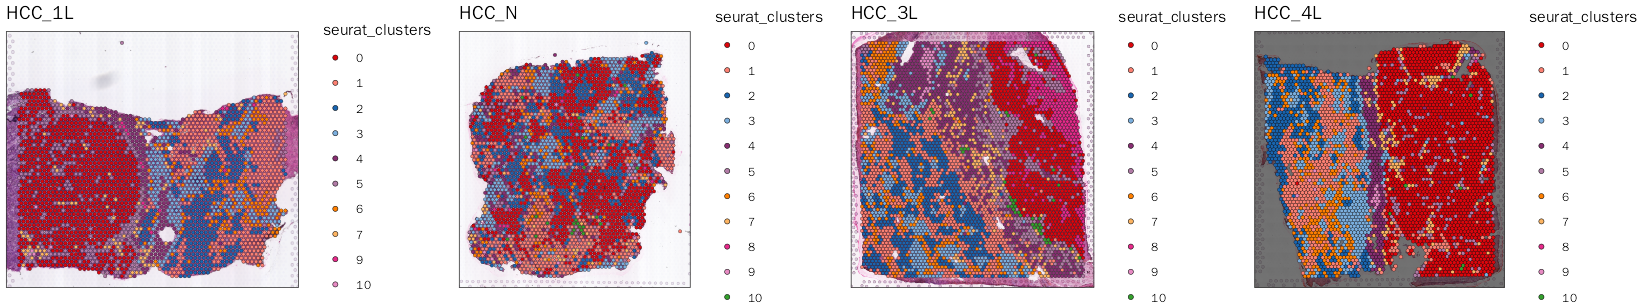

In [ ]:
##marker基因
plot_feature = function (feature){
  p3 = SpatialPlot(ST, features = feature,stroke = 0, pt.size.factor =2,images = 'HCC_1L')
  p1 = SpatialPlot(ST, features = feature,stroke = 0,pt.size.factor = 1.6,images = 'HCC_3L')
  p2 = SpatialPlot(ST, features = feature,stroke = 0,pt.size.factor = 1.6,images = 'HCC_4L')
  p4 = SpatialPlot(ST, features = feature,stroke = 0,pt.size.factor = 1.8,images = 'HCC_N')
  ggarrange(p1,p2,p3,p4,ncol  = 4,nrow = 2)
}

plot_feature(feature=c('HAMP','COL1A1'))

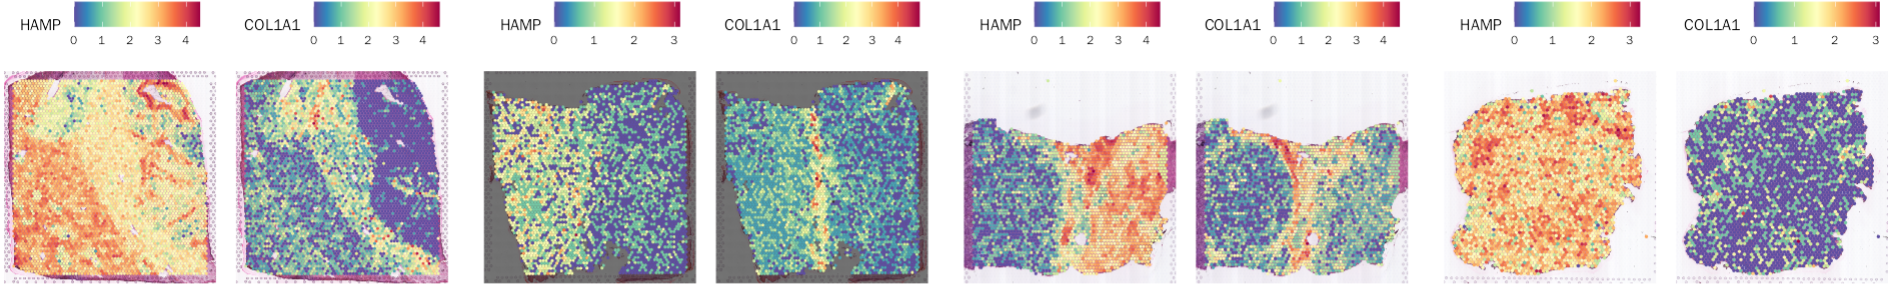

In [ ]:
##cluster相关性计算
library(pheatmap)

Idents(ST)<-ST@meta.data$seurat_clusters
average_expression <- AverageExpression(ST, return.seurat = TRUE,group.by ='seurat_clusters')
average_expression_matrix <- as.data.frame(average_expression@assays$SCT@data)
correlation_matrix <- cor(average_expression_matrix, method = "pearson")
correlation_matrix <- correlation_matrix[as.character(0:10),as.character(0:10)]

pheatmap(correlation_matrix, 
         cluster_rows = F, 
         cluster_cols = F, 
         display_numbers = TRUE, 
         main = "Cluster Correlation",
         color = colorRampPalette(c("navy", "white", "firebrick3"))(100))

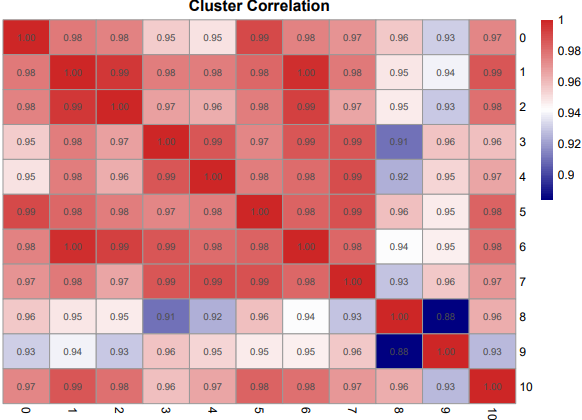

### RCTD 反卷积分析

In [ ]:
library('spacexr')
library('Matrix')

#single cell
load('~/DATA/code/myCode/scRNA.rdata')
col<-c('Hepatocyte'="#1F78B4",'Endothelial'="#B2DF8A",'B'="#55B1B1",
       'Myeloid'="#FDBF6F",'TNK'="#6A3D9A",'Fibroblast'="#A6761D",'Tumor'="#E31A1C")
DimPlot(scRNA, reduction = "umap",group.by = "celltype",label = T,cols = col)

##此处区分恶性Hepatocyte与正常Hepatocyte
scRNA@meta.data$Celltype<-scRNA@meta.data$celltype
scRNA@meta.data$Celltype[scRNA@meta.data$celltype %in% c('Hepatocyte') & scRNA@meta.data$Group %in% c('T')] <- "Tumor"
##RCTD不允许Celltype包括‘/’特殊符号，修改：
scRNA@meta.data$Celltype[scRNA@meta.data$celltype %in% c('T/NK')] <- "TNK"
DimPlot(scRNA, reduction = "umap",group.by = "Celltype",label = T,cols = col,split.by = 'Group')

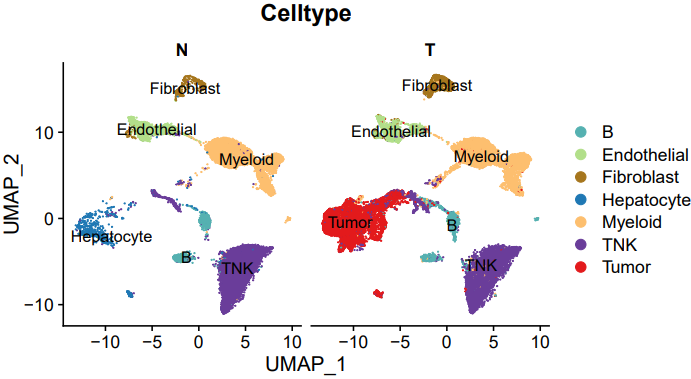

In [ ]:
##提取单细胞metadata,构建reference
meta.data<-scRNA@meta.data
cell_types = as.factor(meta.data$Celltype)
names(cell_types) = rownames(meta.data)
reference <- Reference(scRNA@assays$RNA@counts, cell_types=cell_types)

##ST空间转录组数据读取
input_data_dir = "/home/Data_download/zhaojw/Spatial_data/HCC/HRA000437-outs"
sample_list = list.files(input_data_dir)
lis<-as.data.frame(sample_list)
sample_list = sample_list[c(1:2,4:5)]


##loop RCTD
purrr::map(1:length(sample_list), function(x){
  samples_dir = sample_list %>% file.path(input_data_dir, ., "outs" )
  samples_dir[x]
  puck = read.VisiumSpatialRNA(samples_dir[x])
  #多核报错无"solveIRWLS.weights"函数
  myRCTD <- create.RCTD(puck, reference, max_cores = 1)
  #full mode
  full_myRCTD <- run.RCTD(myRCTD, doublet_mode = 'full')
  full_file_name = paste("~/DATA/code/myCode/ST/RCTD", sample_list[x], ".full.rds.gz",sep="")
  readr::write_rds(full_myRCTD, file=full_file_name,compress = "gz")
})

In [ ]:
##单个样本饼状图展示
myRCTD <- readRDS('~/DATA/code/myCode/ST/HCC-3L.full.rds.gz')
barcodes <- colnames(myRCTD@spatialRNA@counts)
weights <- myRCTD@results$weights
norm_weights <- normalize_weights(weights)
norm_weights <- weights

#借用STdeconvolve绘制一下饼图看看：
library(STdeconvolve)
library(ggplot2)
library(ggsci)

m <- as.matrix(norm_weights)
p <- myRCTD@spatialRNA@coords

#定义颜色：
col_sel=c("#1F78B4","#B2DF8A","#55B1B1","#FDBF6F",
          "#6A3D9A","#A6761D","#E31A1C")

vizAllTopics(theta = m,
                     pos = p,
                     topicOrder=seq(ncol(m)),
                     topicCols=col_sel,
                     groups = NA,
                     group_cols = NA,
                     r = 0.7, # size of scatterpies
                     lwd = 0.2,
                     showLegend = TRUE,
                     plotTitle = "scatterpies")

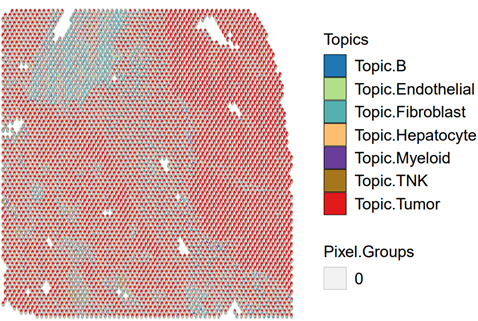

### RCTD normalize_weights

In [ ]:
paths <- list.files("~/DATA/code/myCode/ST")
file_paths = grep('full', paths, value=TRUE)
file_paths = file_paths %>% file.path("~/DATA/code/myCode/ST", .)
file_paths

# 创建一个空列表来存储标准化的权重
norm_weights_list <- list()
# 循环遍历每个文件路径
for (file_path in file_paths) {
  # 读取RCTD结果
  myRCTD <- readRDS(file_path)
  # 提取BC和权重
  barcodes <- colnames(myRCTD@spatialRNA@counts)
  weights <- myRCTD@results$weights
  norm_weights <- normalize_weights(weights)
  
  # 将标准化的权重存储到列表中，以文件名作为键
  file_name <- basename(file_path)
  norm_weights_list[[file_name]] <- norm_weights
}


# 初始化一个空的 DataFrame
merged_df <- data.frame()
# 定义样本前缀
sample_name <- c("HCC_1L_", "HCC_3L_", "HCC_4L_", "HCC_N_")
# 循环处理 normalized_weights_list 并合并到一个 DataFrame 中
for (i in 1:length(file_paths)) {
  file_name <- basename(file_paths[i])
  prefix <- sample_name[i]
  # 创建单个样本的 DataFrame 并添加前缀到行名
  df <- as.data.frame(norm_weights_list[[file_name]])
  rownames(df) <- paste0(prefix, rownames(df))
  # 合并到总的 DataFrame 中
  merged_df <- rbind(merged_df, df)
}


### RCTD结果加至ST@metadata

In [ ]:
ST <- AddMetaData(object = ST, 
                  metadata = merged_df)

plot_feature = function (feature){
  p3 = SpatialPlot(ST, features = feature,stroke = 0, pt.size.factor =2,images = 'HCC_1L')
  p1 = SpatialPlot(ST, features = feature,stroke = 0,pt.size.factor = 1.6,images = 'HCC_3L')
  p2 = SpatialPlot(ST, features = feature,stroke = 0,pt.size.factor = 1.6,images = 'HCC_4L')
  p4 = SpatialPlot(ST, features = feature,stroke = 0,pt.size.factor = 1.8,images = 'HCC_N')
  ggarrange(p1,p2,p3,p4,ncol  = 4,nrow = 1)
}

plot_feature(feature=c('Myeloid'))

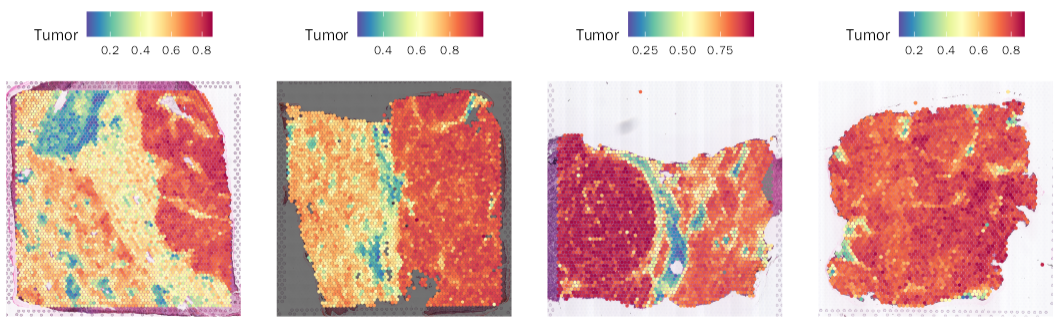

In [ ]:
##根据上一步反卷积结果，进行区域定义
ST@meta.data$Region<-'nMal'
ST@meta.data$Region[ST@meta.data$seurat_clusters %in% c('0','8')] <- "Mal"
ST@meta.data$Region[ST@meta.data$orig.ident %in% c('HCC_N')] <- "PT"
SpatialPlot(ST,group.by = 'Region',cols = c('nMal'='#1F78B4','Mal'='#E31A1C','PT'='#33A02C'))

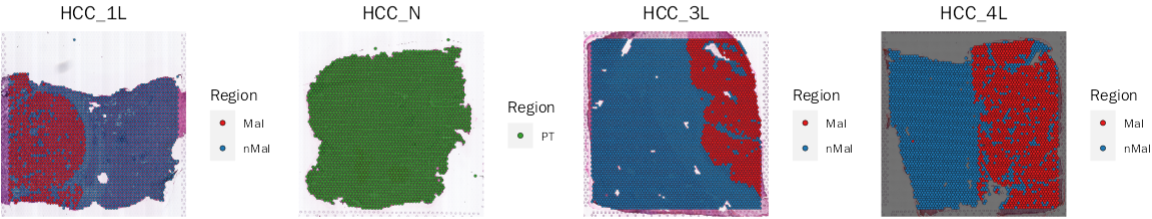

In [ ]:
##Region spot比例
ST@meta.data$Label<-paste(ST@meta.data$Region,ST@meta.data$orig.ident,sep = '_')
library(scRNAtoolVis)
cellRatioPlot(object = ST,
              sample.name = "Label",
              celltype.name = "seurat_clusters",
              flow.curve = 0.5,fill.col = cols)+
  theme(axis.text.x = element_text(angle = 90,hjust = 1))

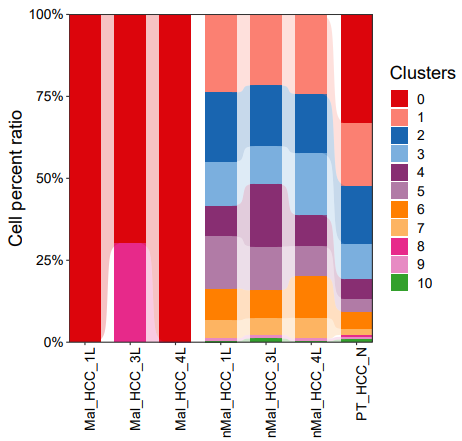

### ST Region GSVA

In [ ]:
library(GSVA) 
library(msigdb)
library(pheatmap)

av <-AverageExpression(ST ,
                       group.by = "Region",
                       assays = "SCT")

av=av[[1]]
head(av)
cg=names(tail(sort(apply(av, 1, sd)),1000))
pheatmap::pheatmap(cor(av[cg,]),  color = colorRampPalette(rev(brewer.pal(n = 7, name ="RdBu")))(100))

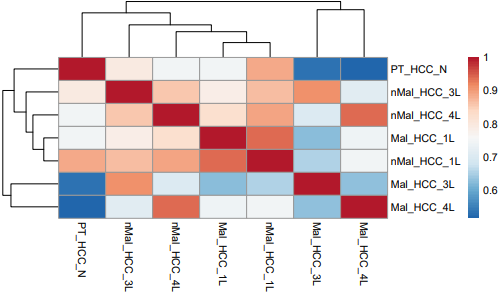

In [ ]:
all_gene_sets = msigdbr(species = "Homo sapiens",
                        category='H') 
unique(all_gene_sets$gs_name)
# 制作gsva分析所需要的genelist
gs=split(all_gene_sets$gene_symbol,all_gene_sets$gs_name)
gs = lapply(gs, unique)
head(gs)
gsc <- GeneSetCollection(mapply(function(geneIds, keggId) {
  GeneSet(geneIds, geneIdType=EntrezIdentifier(),
          collectionType=KEGGCollection(keggId),
          setName=keggId)
}, gs, names(gs)))
head(gsc)
geneset <- gsc

X= av 
# 运行gsva
es.max <- gsva(X, geneset, 
               mx.diff=FALSE, verbose=FALSE, 
               parallel.sz=8)

##删掉每行的HALLMARK_前缀
es.max_sel=es.max
rownames(es.max_sel) <- gsub("^HALLMARK_", "", rownames(es.max_sel))
pheatmap:: pheatmap(es.max_sel ,cluster_rows =T,cluster_cols  =T, border = FALSE, 
         color = colorRampPalette(c("navy", "white", "firebrick3"))(100),
         add_rownames = T,angle_col = 90,fontsize = 8)

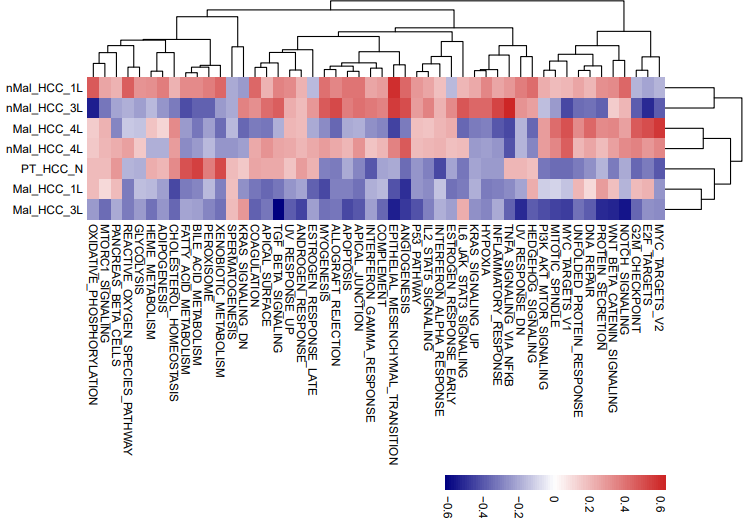

In [ ]:
##气泡图可视化前30通路
library(reshape2)
es.max_sel2<-es.max_sel[1:30,]
# 将数据转换为长格式
data_long <- melt(es.max_sel2)

ggplot(data_long, aes(x = Var1, y = Var2)) +
  geom_point(aes(size = abs(value), fill = value), shape = 21, color = "black") +
  scale_size(range = c(1, 7)) +  # 调整气泡大小范围
  scale_fill_gradientn(colors = colorRampPalette(c("#8968CD", "white", "#EE4000"))(100)) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 1, size = 8, color = "black"),
    axis.text.y = element_text(size = 8, color = "black"),
    panel.border = element_rect(color = "black", fill = NA, size = 1),  # 添加边框
    legend.position = "bottom",  # 将图例放置在下方
    legend.box = "horizontal"  # 水平排列图例
  ) +
  labs(x = "Hallmark Pathway", y = "Region", size = "Abs GSVA Score", fill = "GSVA Score")

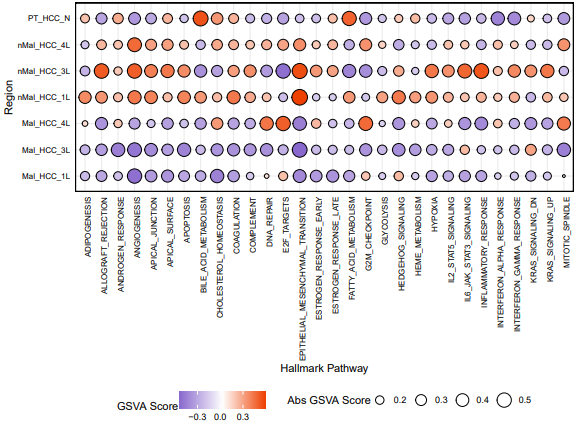

### Cluster-Celltype Correlation

In [ ]:
cell_prop = merged_df %>% 
  as.data.frame() %>%
  rownames_to_column("spot_id") %>%
  pivot_longer(-spot_id)
cell_prop$id<-cell_prop$spot_id

#head(cell_prop)
niche_info = ST@meta.data %>% as.data.frame() %>% 
  rownames_to_column("spot_id") %>%
  select_at(c("spot_id", "orig.ident", "seurat_clusters")) %>%
  dplyr::rename("Niche" = "seurat_clusters") %>%
  mutate(Niche = paste0("Cluster_", Niche))


cellprops_info =  cell_prop  %>%
  left_join(niche_info, c("spot_id" = "spot_id")) %>%
  na.omit()

#head(cellprops_info)
cell_props_summary_CT_pat <- cellprops_info %>%
  group_by(name, Niche) %>%
  summarize(median_CT = median(value))
head(cell_props_summary_CT_pat)

# Check niches that are unique to some patients
cell_prop <-  cell_prop %>%
  left_join(niche_info, c("spot_id" = "spot_id")) %>%
  na.omit() %>%
  dplyr::select(-spot_id) %>%
  group_by(name) %>%
  nest() %>%
  mutate(wres = map(data, function(dat) {
    
    niches <- dat$Niche %>%
      unique() %>%
      set_names()
    
    map(niches, function(g) {
      
      test_data <- dat %>%
        mutate(test_group = ifelse(.data[["Niche"]] == g,
                                   "target", "rest")) %>%
        mutate(test_group = factor(test_group,
                                   levels = c("target", "rest")))
      
      wilcox.test(value ~ test_group, 
                  data = test_data,
                  alternative = "greater") %>%
        broom::tidy()
    }) %>% enframe("Niche") %>%
      unnest()
    
  }))

wilcox_types <- cell_prop %>%
  dplyr::select(wres) %>%
  unnest() %>%
  ungroup() %>%
  dplyr::mutate(adj_pval = p.adjust(p.value)) %>%
  dplyr::mutate(log_adj_pval = -log10(adj_pval)) %>%
  dplyr::mutate(sign = ifelse(adj_pval < 0.005, "*", ""))

#head(wilcox_types)
ct_median_desc <- cell_prop %>%
  dplyr::select(data) %>%
  unnest() %>%
  group_by(name, Niche) %>%
  summarise(median_prop = median(value)) %>%
  mutate(scaled_median_prop = (median_prop - mean(median_prop))/sd(median_prop))
dim(ct_median_desc)

niche_car_df <- left_join(wilcox_types, ct_median_desc) %>% na.omit()
dim(niche_car_df)

ct_median_desc_mat <- niche_car_df %>% dplyr::select(name, Niche, scaled_median_prop) %>%
  pivot_wider(names_from = Niche, values_from = scaled_median_prop) %>%
  column_to_rownames("name") %>%
  as.matrix()

ct_sign_desc_mat <- niche_car_df %>% dplyr::select(name, Niche, sign) %>%
  pivot_wider(names_from = Niche, values_from = sign) %>%
  column_to_rownames("name") %>%
  as.matrix()

ct_median_desc_mat
ct_sign_desc_mat

library("ComplexHeatmap")
col3=colorRampPalette(rev(brewer.pal(9, "PRGn")))(62)
Heatmap(ct_median_desc_mat, name = "scaled comp", 
        col = col3,
        rect_gp = gpar(col = "black", lwd = 1),
        cell_fun = function(j, i, x, y, width, height, fill) {
          grid.text(sprintf(ct_sign_desc_mat[i, j]), x, y, gp = gpar(fontsize = 14))
        })

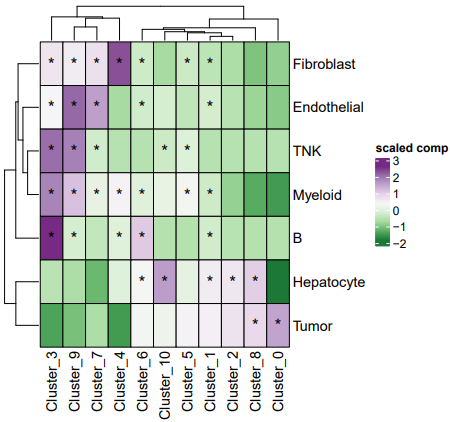

### Written by 孟德尔的豌豆